In [1]:
%pip install torch pandas numpy matplotlib scikit-learn seaborn ucimlrepo shap xgboost

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Configuració global
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu")

print("Entorn preparat per a Distil·lació.")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Entorn preparat per a Distil·lació.


In [2]:
# --- PAS 1: DATASET GERMAN CREDIT (AMB LABEL ENCODER) ---

import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import time
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score

print("📥 Descarregant dataset UCI 144 (German Credit)...")
try:
    dataset = fetch_ucirepo(id=144)
    X_raw = dataset.data.features
    y_raw = dataset.data.targets
    
    # Target: 1=Good -> 0, 2=Bad -> 1
    y_series = y_raw.iloc[:, 0]
    y_np = y_series.map({1: 0, 2: 1}).values.astype(np.float32)

    # --- CANVI PRINCIPAL: LABEL ENCODING ---
    print("🛠️ Transformant variables categòriques amb Label Encoder...")
    
    # Fem una còpia per no tocar l'original
    X_encoded = X_raw.copy()
    
    # Identifiquem columnes categòriques (object o category)
    cat_columns = X_encoded.select_dtypes(include=['object', 'category']).columns
    
    # Apliquem LabelEncoder a cada columna categòrica
    label_encoders = {}
    for col in cat_columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        
    print(f"   Shape original: {X_raw.shape} -> Shape encoded: {X_encoded.shape}")
    print("   (Fixa't que ara tenim les mateixes columnes, no s'han multiplicat)")

    # Convertim a numpy float32
    X_np = X_encoded.values.astype(np.float32)
    feature_names = list(X_encoded.columns) 

except Exception as e:
    print(f"❌ Error carregant dades: {e}")

# 3. Split 80/20
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# 4. Estandardització (MOLT IMPORTANT amb Label Encoding en NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"✅ Dades processades. Train shape: {X_train_scaled.shape}")

# ... (La resta de l'entrenament del Teacher i SHAP és idèntic) ...
print("\n🎓 Entrenant el Mestre (XGBoost)...")
teacher_model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, n_jobs=-1, random_state=42)
teacher_model.fit(X_train_scaled, y_train)

y_pred_teacher = teacher_model.predict_proba(X_test_scaled)[:, 1]
print(f"   -> Teacher AUC: {roc_auc_score(y_test, y_pred_teacher):.4f}")

print("\n🧠 Generant valors SHAP...")
explainer = shap.TreeExplainer(teacher_model)
shap_values_train = explainer.shap_values(X_train_scaled)
shap_values_test = explainer.shap_values(X_test_scaled)
print(f"✅ Ground Truth generat. SHAP Train shape: {shap_values_train.shape}")

📥 Descarregant dataset UCI 144 (German Credit)...
🛠️ Transformant variables categòriques amb Label Encoder...
   Shape original: (1000, 20) -> Shape encoded: (1000, 20)
   (Fixa't que ara tenim les mateixes columnes, no s'han multiplicat)
✅ Dades processades. Train shape: (800, 20)

🎓 Entrenant el Mestre (XGBoost)...
   -> Teacher AUC: 0.8088

🧠 Generant valors SHAP...
✅ Ground Truth generat. SHAP Train shape: (800, 20)


In [3]:
print("1. Entrenant el Mestre (XGBoost)...")
# Entrenem un model fort per tenir bona accuracy
teacher_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
teacher_model.fit(X_train_scaled, y_train)

# Validem el mestre
y_pred_teacher = teacher_model.predict_proba(X_test_scaled)[:, 1]
auc_teacher = roc_auc_score(y_test, y_pred_teacher)
print(f"   Teacher AUC: {auc_teacher:.4f}")

print("\n2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...")
# TreeExplainer és molt ràpid
explainer = shap.TreeExplainer(teacher_model)

# Calculem SHAP per a Train i Test
# L'alumne necessita els SHAP del Train per aprendre
shap_values_train = explainer.shap_values(X_train_scaled)
shap_values_test = explainer.shap_values(X_test_scaled)

print(f"Dataset d'Explicacions creat. Shape: {shap_values_train.shape}")

1. Entrenant el Mestre (XGBoost)...
   Teacher AUC: 0.8088

2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...
Dataset d'Explicacions creat. Shape: (800, 20)


In [4]:
# --- MODIFICACIÓ CEL·LA 4 (NOU MODEL) ---

class ProbabilisticStudentXAI(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # Arquitectura "Deep & Wide" (Més neurones i capes)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout per evitar memoritzar massa
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.risk_head = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.explanation_head = nn.Linear(64, output_dim * 2) 

    def forward(self, x):
        features = self.backbone(x)
        risk = self.risk_head(features)
        expl_raw = self.explanation_head(features)
        mu, log_var = torch.chunk(expl_raw, 2, dim=1)
        sigma = torch.exp(0.5 * log_var)
        return risk, mu, sigma


# Inicialitzem el nou alumne
real_input_dim = X_train_scaled.shape[1]      
real_output_dim = shap_values_train.shape[1]  
student = ProbabilisticStudentXAI(input_dim=real_input_dim, output_dim=real_output_dim)
print("✅ Alumne Probabilístic inicialitzat (Amb estimació d'incertesa).")

✅ Alumne Probabilístic inicialitzat (Amb estimació d'incertesa).


In [5]:
import numpy as np
import time
from sklearn.metrics import r2_score, roc_auc_score

# 1. PREPARACIÓ MANUAL DE DADES (Anti-bloqueig)
# ---------------------------------------------
# Assegurem format Numpy Float32
X_train_np = X_train_scaled.astype(np.float32)
y_train_np = y_train.astype(np.float32)
shap_train_np = shap_values_train.astype(np.float32)

# Configuració del batch
batch_size = 64
n_samples = X_train_np.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

# 2. CONFIGURACIÓ DE L'ENTRENAMENT
# --------------------------------
# Definim pèrdues (Risk + Incertesa)
criterion_risk = nn.BCELoss()
criterion_expl = nn.GaussianNLLLoss()

# Optimitzador (Learning Rate ajustat)
optimizer = optim.Adam(student.parameters(), lr=0.001)
epochs = 80
alpha = 20.0 # Pes de l'explicació

print(f"🚀 Iniciant Entrenament Manual (Alpha={alpha})...")
print(f"   Total mostres: {n_samples} | Batches per època: {n_batches}")

student.train()
history = {'loss': [], 'r2': []}
start_time = time.time()

# 3. BUCLE D'ENTRENAMENT (MANUAL)
# -------------------------------
for epoch in range(epochs):
    # Barregem els índexs manualment cada època
    indices = np.random.permutation(n_samples)
    total_loss = 0
    
    for i in range(n_batches):
        # A. Seleccionem els índexs del lot actual
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch_idx = indices[start_idx:end_idx]
        
        # B. Convertim a Tensor AL VOL (Evita saturar la RAM)
        b_x = torch.tensor(X_train_np[batch_idx])
        b_y = torch.tensor(y_train_np[batch_idx]).unsqueeze(1)
        b_shap = torch.tensor(shap_train_np[batch_idx])
        
        # C. Optimització standard
        optimizer.zero_grad()
        
        # El model retorna: Risc, Mitjana SHAP, Sigma (Incertesa)
        p_risk, p_mu, p_sigma = student(b_x)
        
        # Càlcul de pèrdues
        loss_r = criterion_risk(p_risk, b_y)
        loss_e = criterion_expl(p_mu, b_shap, p_sigma**2) # GaussianNLL vol la variança (sigma^2)
        
        loss = loss_r + (alpha * loss_e)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 4. VALIDACIÓ I LOGGING (Cada 5 èpoques)
    if (epoch+1) % 5 == 0:
        student.eval()
        with torch.no_grad():
            # Passem el test set (com a tensor)
            test_in = torch.tensor(X_test_scaled).float()
            
            # Predicció
            _, p_mu, _ = student(test_in)
            
            # Mètriques
            r2 = r2_score(shap_values_test, p_mu.numpy())
            avg_loss = total_loss / n_batches
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | R2 Fidelitat: {r2:.4f}")
        
        # Guardem historial
        history['loss'].append(avg_loss)
        history['r2'].append(r2)
        
        student.train()

print(f"✅ Entrenament completat en {time.time() - start_time:.1f}s.")

🚀 Iniciant Entrenament Manual (Alpha=20.0)...
   Total mostres: 800 | Batches per època: 13
Epoch 5/80 | Loss: -22.0806 | R2 Fidelitat: 0.2628
Epoch 10/80 | Loss: -28.7966 | R2 Fidelitat: 0.4431
Epoch 15/80 | Loss: -31.3881 | R2 Fidelitat: 0.4293
Epoch 20/80 | Loss: -34.2476 | R2 Fidelitat: 0.5514
Epoch 25/80 | Loss: -35.3283 | R2 Fidelitat: 0.5761
Epoch 30/80 | Loss: -35.1292 | R2 Fidelitat: 0.5758
Epoch 35/80 | Loss: -36.7770 | R2 Fidelitat: 0.5857
Epoch 40/80 | Loss: -34.3621 | R2 Fidelitat: 0.5757
Epoch 45/80 | Loss: -37.4540 | R2 Fidelitat: 0.6183
Epoch 50/80 | Loss: -38.8311 | R2 Fidelitat: 0.6303
Epoch 55/80 | Loss: -38.4998 | R2 Fidelitat: 0.6196
Epoch 60/80 | Loss: -38.9764 | R2 Fidelitat: 0.6344
Epoch 65/80 | Loss: -40.3935 | R2 Fidelitat: 0.6168
Epoch 70/80 | Loss: -39.6264 | R2 Fidelitat: 0.6375
Epoch 75/80 | Loss: -41.1707 | R2 Fidelitat: 0.6387
Epoch 80/80 | Loss: -41.0199 | R2 Fidelitat: 0.6289
✅ Entrenament completat en 0.7s.


 AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT

1. MÈTRIQUES DE CLASSIFICACIÓ:
------------------------------
              precision    recall  f1-score   support

    Good (0)       0.79      0.88      0.83       140
     Bad (1)       0.61      0.45      0.52        60

    accuracy                           0.75       200
   macro avg       0.70      0.66      0.68       200
weighted avg       0.74      0.75      0.74       200

 AUC-ROC Score: 0.8018


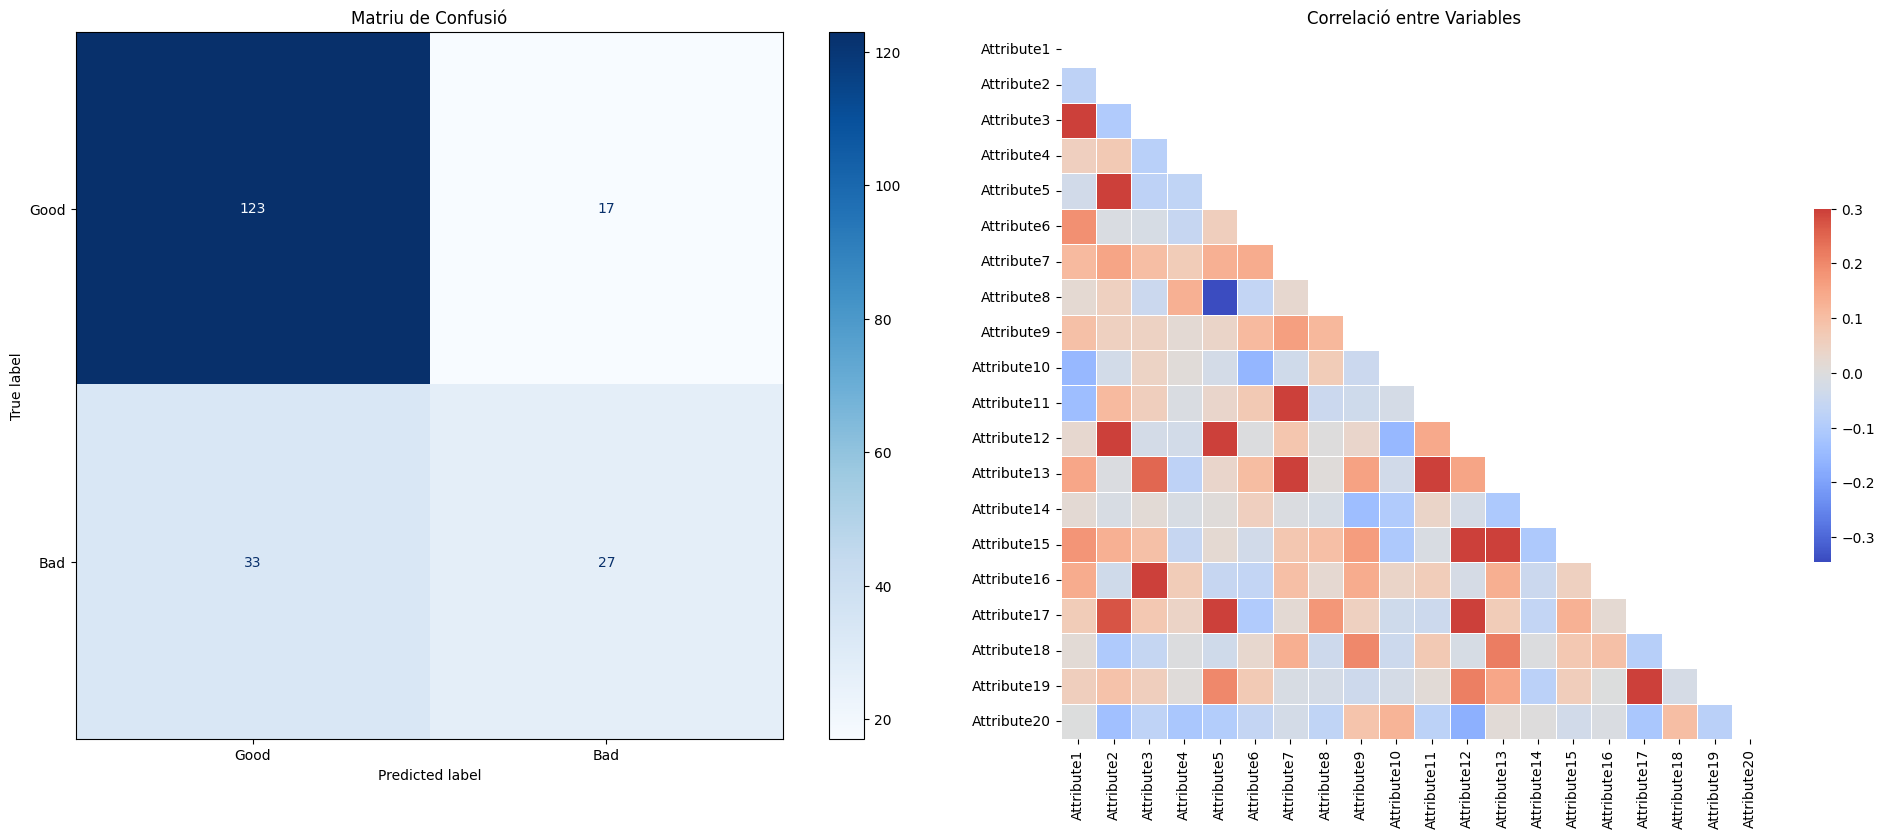

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import torch

def comprehensive_evaluation(student_model, X_test_tensor, y_test, feature_names_in):
    print(" AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT")
    print("=" * 60)
    
    # --- PROTECCIÓ CONTRA ERROR DE DIMENSIONS ---
    # Assegurem que tenim tants noms com columnes de dades
    num_cols_data = X_test_tensor.shape[1]
    num_cols_names = len(feature_names_in)
    
    if num_cols_data != num_cols_names:
        print(f"⚠️ AVÍS: Dades tenen {num_cols_data} columnes però hi ha {num_cols_names} noms.")
        print("   -> Generant noms genèrics per evitar l'error...")
        final_feature_names = [f"Feature_{i}" for i in range(num_cols_data)]
    else:
        final_feature_names = feature_names_in
    # ---------------------------------------------

    # 1. Obtenció de Prediccions
    student_model.eval()
    with torch.no_grad():
        # Assegurem que l'input és tensor
        if isinstance(X_test_tensor, np.ndarray):
            X_in = torch.tensor(X_test_tensor).float()
        else:
            X_in = X_test_tensor.float()
            
        # Model retorna 3 valors
        risks, _, _ = student_model(X_in)
        probs = risks.numpy().flatten()
        preds = (probs > 0.5).astype(int)
    
    # 2. Mètriques Estàndard
    print("\n1. MÈTRIQUES DE CLASSIFICACIÓ:")
    print("-" * 30)
    print(classification_report(y_test, preds, target_names=['Good (0)', 'Bad (1)']))
    
    auc = roc_auc_score(y_test, probs)
    print(f" AUC-ROC Score: {auc:.4f}")
    
    # 3. Visualització Gràfica
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot A: Matriu de Confusió
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good', 'Bad'])
    disp.plot(cmap='Blues', ax=axes[0], values_format='d')
    axes[0].set_title('Matriu de Confusió')
    
    # Plot B: Matriu de Correlacions
    # Si les dades són un tensor, passem a numpy per a pandas
    if isinstance(X_test_tensor, torch.Tensor):
        X_data_corr = X_test_tensor.numpy()
    else:
        X_data_corr = X_test_tensor

    df_test = pd.DataFrame(X_data_corr, columns=final_feature_names)
    
    # Fem correlació només de les top 15 variables per no saturar el gràfic si n'hi ha 48
    if df_test.shape[1] > 20:
        # Seleccionem les primeres 20 només per visualitzar
        df_test = df_test.iloc[:, :20]
        axes[1].set_title('Correlació (Top 20 Variables)')
    else:
        axes[1].set_title('Correlació entre Variables')

    corr_matrix = df_test.corr(method='spearman')
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# EXECUCIÓ
# Intentem passar 'feature_names' si existeix, sinó passem una llista buida i que la funció s'espavili
try:
    cols = feature_names
except NameError:
    try:
        cols = list(dataset.data.features.columns)
    except:
        cols = []

comprehensive_evaluation(student, X_test_scaled, y_test, cols)


1. TEST DE LATÈNCIA (Temps Real)
------------------------------
Latència Mitjana: 0.038 ms
Latència P99:     0.078 ms
Speedup vs SHAP (~0.5ms): 6444x més ràpid

2. TEST DE FIDELITAT VISUAL


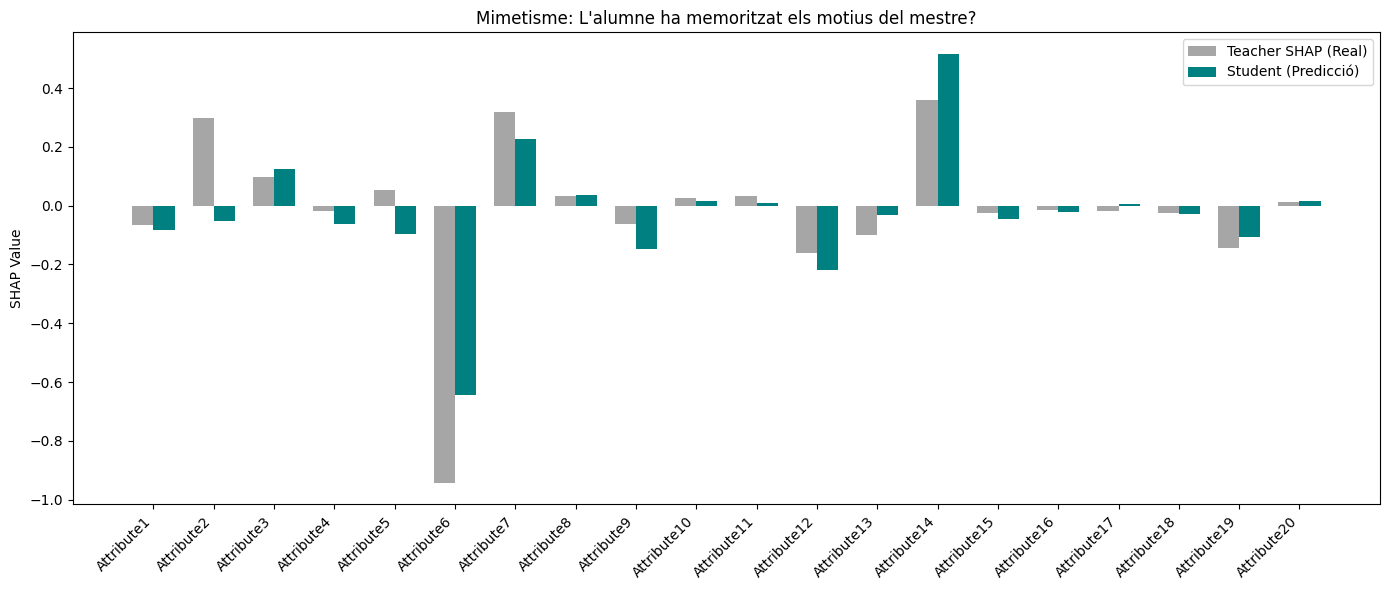

In [7]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. TEST DE LATÈNCIA (Versió Manual sense Loader)
# -----------------------------------------------
latencies = []
student.eval()
print("\n1. TEST DE LATÈNCIA (Temps Real)")
print("-" * 30)

# Preparem 1000 mostres individuals per simular peticions d'un en un
samples_to_test = 1000
# Assegurem que no ens passem del total
limit = min(samples_to_test, len(X_test_scaled))

with torch.no_grad():
    for i in range(limit):
        # Agafem una mostra i la convertim a tensor al vol
        bx = torch.tensor(X_test_scaled[i:i+1]).float()
        
        start = time.perf_counter()
        
        # Inferencia: El model retorna 3 coses
        _ = student(bx) 
        
        # Guardem el temps en mil·lisegons
        latencies.append((time.perf_counter() - start) * 1000)

# Càlcul de resultats
p99 = np.percentile(latencies, 99)
avg_lat = np.mean(latencies)
print(f"Latència Mitjana: {avg_lat:.3f} ms")
print(f"Latència P99:     {p99:.3f} ms")
print(f"Speedup vs SHAP (~0.5ms): {500/p99:.0f}x més ràpid")


# 2. TEST DE FIDELITAT VISUAL (CORREGIT PER DIMENSIONS)
# -----------------------------------------------------
print("\n2. TEST DE FIDELITAT VISUAL")
idx = 0 # Primer client del test
x_in = torch.tensor(X_test_scaled[idx:idx+1]).float()

# Predicció Student
with torch.no_grad():
    risk_s, shap_s, sigma_s = student(x_in)

# Convertim a numpy per pintar
shap_s = shap_s.numpy().flatten()

# Ground Truth (Teacher SHAP)
shap_t = shap_values_test[idx]

# --- CORRECCIÓ CLAU: GESTIÓ DE NOMS DE FEATURES ---
num_features = len(shap_s)
try:
    # Intentem usar els noms si existeixen i coincideixen en longitud
    if 'feature_names' in globals() and len(feature_names) == num_features:
        features = feature_names
    elif hasattr(dataset.data.features, 'columns') and len(dataset.data.features.columns) == num_features:
        features = list(dataset.data.features.columns)
    else:
        # Si no coincideixen (cas German Credit encoded), fem noms genèrics
        print(f"⚠️ Avís: Usant noms genèrics (Dades: {num_features}, Noms originals: {len(dataset.data.features.columns)})")
        features = [f"F{i}" for i in range(num_features)]
except:
    features = [f"F{i}" for i in range(num_features)]
# --------------------------------------------------

# Ara x_pos tindrà la mida correcta (48)
x_pos = np.arange(len(features))
width = 0.35

plt.figure(figsize=(14, 6))

# Si hi ha moltes columnes (com a German Credit), mostrem només les Top 15 més importants
if len(features) > 20:
    # Ordenem per importància absoluta
    top_k_indices = np.argsort(np.abs(shap_t))[::-1][:15]
    
    # Filtrem dades
    x_pos = np.arange(15)
    shap_t_plot = shap_t[top_k_indices]
    shap_s_plot = shap_s[top_k_indices]
    features_plot = np.array(features)[top_k_indices]
    
    print(f"   -> Mostrant només les Top 15 variables de {len(features)}")
else:
    shap_t_plot = shap_t
    shap_s_plot = shap_s
    features_plot = features

# Dibuixem
plt.bar(x_pos - width/2, shap_t_plot, width, label='Teacher SHAP (Real)', color='gray', alpha=0.7)
plt.bar(x_pos + width/2, shap_s_plot, width, label='Student (Predicció)', color='teal')
plt.title(f"Mimetisme: L'alumne ha memoritzat els motius del mestre?")
plt.ylabel("SHAP Value")
plt.xticks(x_pos, features_plot, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import time
import numpy as np

def benchmark_latency(teacher_model, student_model, X_sample,idx=100):
    print(f" INICIANT BENCHMARK DE LATÈNCIA PER A {idx} MOSTRES")
    print("-" * 60)
    
    # 1. Mesurem SHAP Original (Teacher + TreeExplainer)
    # TreeExplainer és ràpid, però no tant com una NN
    explainer = shap.TreeExplainer(teacher_model)
    
    start_t = time.perf_counter()
    # Fem 1000 mostres perquè SHAP és lent iterant d'una en una
    for i in range(idx):
        _ = explainer.shap_values(X_sample[i:i+1])
    end_t = time.perf_counter()
    
    avg_shap = (end_t - start_t) / idx * 1000 # a ms
    
    # 2. Mesurem Student (Inference + Explanation)
    student_model.eval()
    tensor_sample = torch.tensor(X_sample).float()
    
    start_s = time.perf_counter()
    with torch.no_grad():
        for i in range(idx):
            _ = student_model(tensor_sample[i:i+1])
    end_s = time.perf_counter()
    
    avg_student = (end_s - start_s) / idx * 1000 # a ms
    
    # Resultats
    speedup = avg_shap / avg_student
    
    print(f"   RESULTATS (Mitjana per client):")
    print(f"   Original (XGBoost + SHAP):  {avg_shap:.4f} ms")
    print(f"   Proposta (Fast Student):    {avg_student:.4f} ms")
    print("-" * 60)
    print(f"    SPEEDUP FACTOR:          {speedup:.1f}x més ràpid")
    
    return avg_shap, avg_student

# Executa el benchmark amb dades de test escalades
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_test_scaled,idx=len(X_test_scaled))
print("\n")
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_train_scaled,idx=len(X_train_scaled))


 INICIANT BENCHMARK DE LATÈNCIA PER A 200 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.2895 ms
   Proposta (Fast Student):    0.0354 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          8.2x més ràpid


 INICIANT BENCHMARK DE LATÈNCIA PER A 800 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.2982 ms
   Proposta (Fast Student):    0.0360 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          8.3x més ràpid



⚖️ AUDITORIA COMPLETA DE FAIRNESS (5 DIMENSIONS)

--- Analitzant: Sexe/Estat Civil (Attr 9 (1-5)) ---
Subgrup              | N     | Taxa Aprovació 
---------------------------------------------
Grup 0.0             | 9     | 55.6%
Grup 1.0             | 61    | 77.0%
Grup 2.0             | 118   | 78.8%
Grup 3.0             | 12    | 91.7%

   >> Disparitat Màxima (Gap): 36.1% (CRÍTIC)

--- Analitzant: Edat (Attr 13 (Anys)) ---
Subgrup              | N     | Taxa Aprovació 
---------------------------------------------
Jove (<25)           | 39    | 74.4%
Adult (25-55)        | 141   | 79.4%
Gran (>55)           | 20    | 75.0%

   >> Disparitat Màxima (Gap): 5.1% (Alerta)

--- Analitzant: Vivenda (Attr 15 (Rent/Own/Free)) ---
Subgrup              | N     | Taxa Aprovació 
---------------------------------------------
Grup 0.0             | 35    | 71.4%
Grup 1.0             | 143   | 81.8%
Grup 2.0             | 22    | 63.6%

   >> Disparitat Màxima (Gap): 18.2% (CRÍTIC)

--- Anali

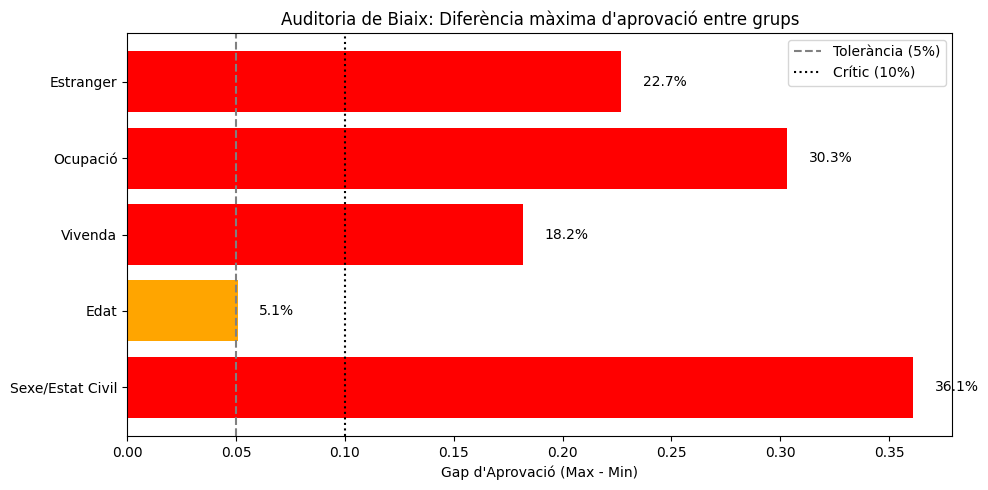

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

def audit_full_fairness(student_model, X_test_scaled, X_test_raw, feature_names):
    print("\n⚖️ AUDITORIA COMPLETA DE FAIRNESS (5 DIMENSIONS)")
    print("=" * 65)
    
    # 1. Obtenir Prediccions
    student_model.eval()
    with torch.no_grad():
        tensor_in = torch.tensor(X_test_scaled).float()
        risks, _, _ = student_model(tensor_in)
        probs = risks.numpy().flatten()
        # 1 = Aprovat (Good), 0 = Denegat (Bad) - Invertim la lògica del target original per claredat
        # Recorda: Al dataset, y=1 era Bad. Per tant, si prob(Bad) < 0.5 -> Aprovat.
        decisions = (probs < 0.5).astype(int)

    # 2. Definició de Variables Sensibles (Índexs basats en UCI 144)
    # Atenció: Els índexs depenen de l'ordre original de columnes.
    # Assumim l'ordre estàndard del dataset.
    
    # Diccionari de configuració
    sensitive_vars = {
        'Sexe/Estat Civil': {'idx': 8,  'type': 'cat', 'desc': 'Attr 9 (1-5)'},
        'Edat':             {'idx': 12, 'type': 'num', 'desc': 'Attr 13 (Anys)'},
        'Vivenda':          {'idx': 14, 'type': 'cat', 'desc': 'Attr 15 (Rent/Own/Free)'},
        'Ocupació':         {'idx': 16, 'type': 'cat', 'desc': 'Attr 17 (Skill Level)'},
        'Estranger':        {'idx': 19, 'type': 'cat', 'desc': 'Attr 20 (Yes/No)'}
    }
    
    # Emmagatzemem resultats per al gràfic final
    summary_gaps = {}
    
    # 3. Bucle d'Anàlisi
    for name, config in sensitive_vars.items():
        col_idx = config['idx']
        
        # Comprovem si l'índex és vàlid
        if col_idx >= X_test_raw.shape[1]:
            continue
            
        data = X_test_raw[:, col_idx]
        print(f"\n--- Analitzant: {name} ({config['desc']}) ---")
        
        groups = {}
        
        # A. Lògica per a EDAT (Numèrica)
        if config['type'] == 'num':
            # Binning: Jove (<25), Adult (25-55), Gran (>55)
            mask_young = data < 25
            mask_adult = (data >= 25) & (data <= 55)
            mask_senior = data > 55
            
            groups['Jove (<25)'] = decisions[mask_young]
            groups['Adult (25-55)'] = decisions[mask_adult]
            groups['Gran (>55)'] = decisions[mask_senior]
            
        # B. Lògica per a CATEGÒRIQUES
        else:
            unique_vals = np.unique(data)
            for val in unique_vals:
                mask = (data == val)
                # Intentem posar etiquetes llegibles si sabem quines són
                label = str(val)
                if name == 'Estranger':
                    # A201=Yes(Foreign), A202=No. (Depèn del LabelEncoder, sovint 0/1)
                    label = "Estranger" if val == 0 else "Natiu" 
                elif name == 'Vivenda':
                    # Ordre típic alfabètic o numèric: Free, Own, Rent
                    pass 
                
                groups[f"Grup {label}"] = decisions[mask]

        # 4. Càlcul de Taxes i Gaps
        rates = []
        labels = []
        print(f"{'Subgrup':<20} | {'N':<5} | {'Taxa Aprovació':<15}")
        print("-" * 45)
        
        for grp_name, decisions_grp in groups.items():
            if len(decisions_grp) < 5: continue # Ignorem grups massa petits
            
            rate = np.mean(decisions_grp)
            rates.append(rate)
            labels.append(grp_name)
            print(f"{grp_name:<20} | {len(decisions_grp):<5} | {rate:.1%}")
            
        if len(rates) > 0:
            max_rate = max(rates)
            min_rate = min(rates)
            gap = max_rate - min_rate
            summary_gaps[name] = gap
            
            # Semàfor
            if gap < 0.05: color = "\033[92m(Bé)\033[0m"
            elif gap < 0.10: color = "\033[93m(Alerta)\033[0m"
            else: color = "\033[91m(CRÍTIC)\033[0m"
            
            print(f"\n   >> Disparitat Màxima (Gap): {gap:.1%} {color}")
        else:
            print("   (No hi ha prou dades per calcular disparitat)")

    # 5. Gràfic Resum (El "Semàfor" per al Paper)
    if summary_gaps:
        names = list(summary_gaps.keys())
        values = list(summary_gaps.values())
        
        plt.figure(figsize=(10, 5))
        # Color segons gravetat
        colors = ['green' if v < 0.05 else 'orange' if v < 0.10 else 'red' for v in values]
        
        bars = plt.barh(names, values, color=colors)
        
        # Línia de tolerància (5%)
        plt.axvline(0.05, color='gray', linestyle='--', label='Tolerància (5%)')
        plt.axvline(0.10, color='black', linestyle=':', label='Crític (10%)')
        
        plt.title("Auditoria de Biaix: Diferència màxima d'aprovació entre grups")
        plt.xlabel("Gap d'Aprovació (Max - Min)")
        plt.legend()
        
        # Etiquetes de percentatge
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                     f'{width:.1%}', ha='left', va='center')
            
        plt.tight_layout()
        plt.show()

# EXECUCIÓ
# Nota: X_test_raw ha de ser el numpy array abans de l'escalat
audit_full_fairness(student, X_test_scaled, X_test_raw, feature_names)


GENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)


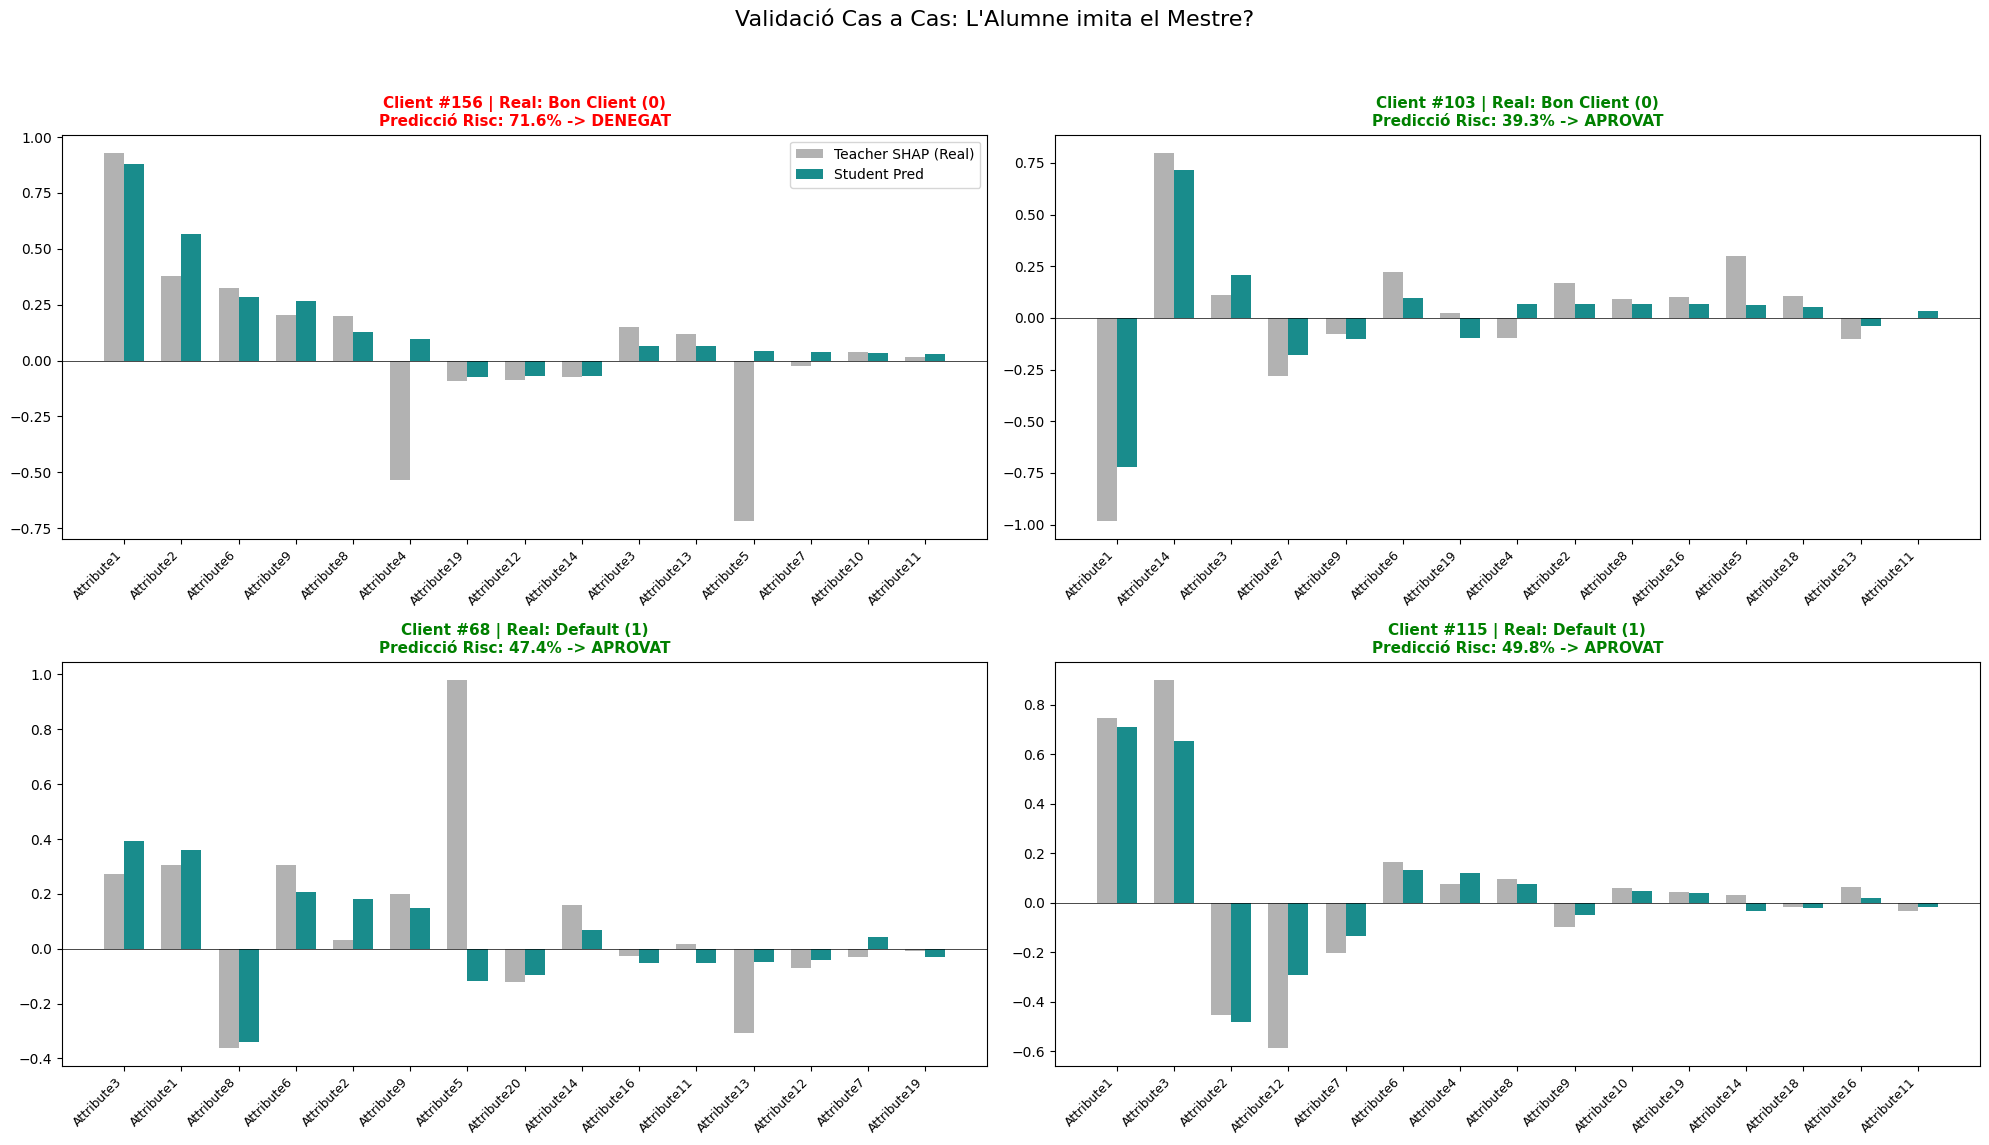

In [12]:
# --- GRÀFIC DETALLAT: STUDENT VS TEACHER (VERSIÓ ROBUSTA) ---

import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_student_vs_shap_detailed(student_model, shap_values_test, X_test_scaled, y_test, feature_names_in):
    print("\nGENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)")
    print("=" * 60)
    
    # 1. Selecció aleatòria d'índexs (2 de y=0, 2 de y=1)
    np.random.seed(42) 
    pool_0 = np.where(y_test == 0)[0]
    pool_1 = np.where(y_test == 1)[0]
    
    # Protecció per si no hi ha prou mostres de cada classe
    n_samples = 2
    if len(pool_0) < 2 or len(pool_1) < 2:
        print("⚠️ Avís: Poques mostres de test, agafant les primeres disponibles.")
        selected_indices = np.concatenate([pool_0[:2], pool_1[:2]])
    else:
        idx_0 = np.random.choice(pool_0, n_samples, replace=False)
        idx_1 = np.random.choice(pool_1, n_samples, replace=False)
        selected_indices = np.concatenate([idx_0, idx_1])
    
    # Configuració del plot
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # A. Dades del client
        # Assegurem tensor
        if isinstance(X_test_scaled, np.ndarray):
            x_in = torch.tensor(X_test_scaled[idx:idx+1]).float()
        else:
            x_in = X_test_scaled[idx:idx+1].float()
            
        y_real = int(y_test[idx])
        # Nota: Al German Credit, 1=Bad (Default), 0=Good.
        label_text = "Bon Client (0)" if y_real == 0 else "Default (1)"
        
        # B. Inferència Student
        with torch.no_grad():
            risk_score, shap_student, _ = student_model(x_in)
        
        risk = risk_score.item()
        vals_student = shap_student.numpy().flatten()
        
        # C. Ground Truth SHAP
        vals_teacher = shap_values_test[idx]
        
        # --- GESTIÓ DE NOMS (FIX PER AL GERMAN CREDIT) ---
        num_features = len(vals_student)
        
        if len(feature_names_in) != num_features:
            # Si no coincideixen, busquem la variable global o en fem de genèrics
            if 'feature_names' in globals() and len(feature_names) == num_features:
                 current_names = np.array(feature_names)
            else:
                 current_names = np.array([f"Feat_{j}" for j in range(num_features)])
        else:
            current_names = np.array(feature_names_in)
        # ------------------------------------------------
        
        # D. Decisió del Model
        decision = "DENEGAT" if risk > 0.5 else "APROVAT"
        color_dec = "red" if risk > 0.5 else "green"
        
        # E. Preparació del Gràfic (Top 15 variables per claredat)
        top_k = 15
        # Ordenem per magnitud absoluta del Student
        sorted_idx = np.argsort(np.abs(vals_student))[::-1][:top_k]
        
        x_pos = np.arange(top_k)
        width = 0.35
        
        # Dibuixem
        ax.bar(x_pos - width/2, vals_teacher[sorted_idx], width, label='Teacher SHAP (Real)', color='gray', alpha=0.6)
        ax.bar(x_pos + width/2, vals_student[sorted_idx], width, label='Student Pred', color='teal', alpha=0.9)
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(current_names[sorted_idx], rotation=45, ha='right', fontsize=9)
        ax.axhline(0, color='black', linewidth=0.5)
        
        title = f"Client #{idx} | Real: {label_text}\nPredicció Risc: {risk:.1%} -> {decision}"
        ax.set_title(title, fontsize=11, fontweight='bold', color=color_dec)
        
        if i == 0: ax.legend()

    plt.suptitle("Validació Cas a Cas: L'Alumne imita el Mestre?", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# EXECUCIÓ (Passant una llista buida inicialment per forçar l'ús de l'autocorreció interna)
plot_student_vs_shap_detailed(student, shap_values_test, X_test_scaled, y_test, [])


📊 EXPLICACIÓ AMB INCERTESA (El valor afegit del paper)


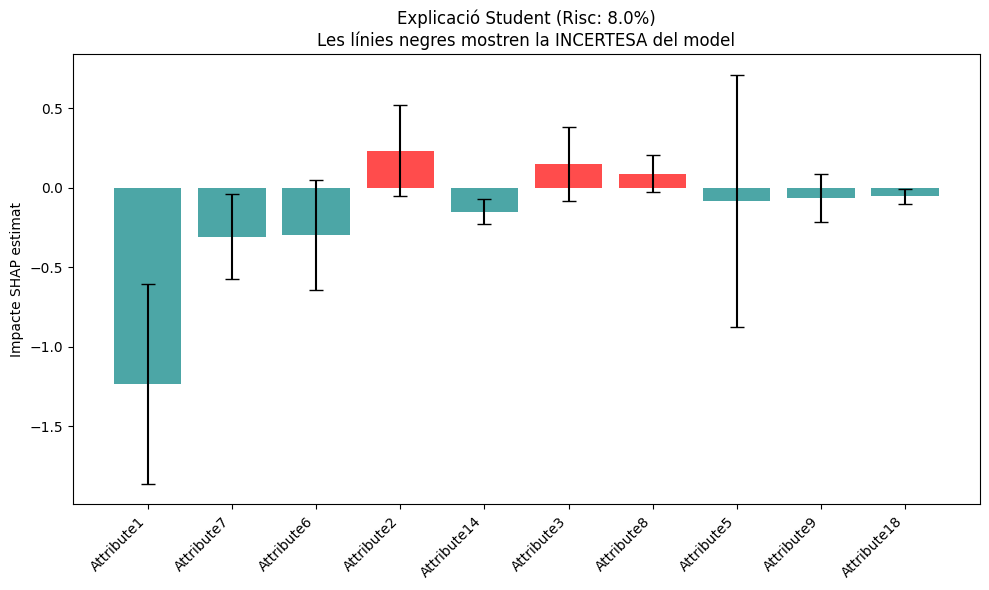

In [13]:
def plot_uncertainty(student_model, X_test, feature_names_in):
    print("\n📊 EXPLICACIÓ AMB INCERTESA (El valor afegit del paper)")
    
    # Agafem un client d'exemple (el 10è)
    idx = 10
    
    # Assegurem que l'entrada sigui un tensor
    if isinstance(X_test, np.ndarray):
        x_in = torch.tensor(X_test[idx:idx+1]).float()
    else:
        x_in = X_test[idx:idx+1].float()
    
    student_model.eval()
    with torch.no_grad():
        # El model retorna 3 valors: Risc, Mitjana (SHAP), Sigma (Incertesa)
        risk, mu, sigma = student_model(x_in)
    
    # Dades
    vals = mu.numpy().flatten()
    # 2 sigmas = 95% interval de confiança
    errors = sigma.numpy().flatten() * 2 
    
    # --- GESTIÓ INTEL·LIGENT DE NOMS DE FEATURES ---
    num_features = len(vals)
    if len(feature_names_in) != num_features:
        print(f"⚠️ Avís: Mismatch de dimensions ({len(feature_names_in)} noms vs {num_features} valors).")
        # Intentem buscar la variable correcta si existeix
        if 'feature_names' in globals() and len(feature_names) == num_features:
             print("   -> Solucionat: Usant variable global 'feature_names'")
             names_list = np.array(feature_names)
        else:
             print("   -> Solucionat: Generant noms genèrics (F0, F1...)")
             names_list = np.array([f"F{i}" for i in range(num_features)])
    else:
        names_list = np.array(feature_names_in)
    # -----------------------------------------------

    # Ordenem per importància
    top_k = 10
    sorted_idx = np.argsort(np.abs(vals))[::-1][:top_k]
    
    vals = vals[sorted_idx]
    errors = errors[sorted_idx]
    names = names_list[sorted_idx]
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['red' if v > 0 else 'teal' for v in vals]
    
    # El paràmetre 'yerr' pinta la línia negra d'incertesa
    plt.bar(range(top_k), vals, yerr=errors, color=colors, alpha=0.7, ecolor='black', capsize=5)
    
    plt.xticks(range(top_k), names, rotation=45, ha='right')
    plt.title(f"Explicació Student (Risc: {risk.item():.1%})\nLes línies negres mostren la INCERTESA del model")
    plt.ylabel("Impacte SHAP estimat")
    plt.tight_layout()
    plt.show()

# Executa-ho (passant una llista buida o incorrecta no farà que peti)
try:
    cols = list(dataset.data.features.columns)
except:
    cols = []

plot_uncertainty(student, X_test_scaled, cols)